### Download Data

The data is taken from http://archive.ics.uci.edu/ml/machine-learning-databases/00240/, but you can have it in the form of the UCI-HAR-Dataset.zip.

Extract it to the folder of your notebook with the solution (or suitably adjust the paths to training and test data specified below (TRAIN, TEST).  

Spcifically, the split into training and testing data is already done. The dataset contains 7352 training and 2947 test samples.  

Each sample consists of nine timeseries of float values, each of length 128.

The nine timeseries are collected by an accelerometer and a gyroscope that contain information about the motion and the orientation, respectively.

In [1]:
import os

import numpy as np
import matplotlib
import matplotlib.pyplot as plt

### Load Data

In [2]:
# Useful Constants
TRAIN = "UCI_HAR_Dataset/train/"
TEST = "UCI_HAR_Dataset/test/"

# x-values, 'signals'
# Those are separate normalised input features for the neural network
INPUT_SIGNAL_TYPES = [
    "body_acc_x_",
    "body_acc_y_",
    "body_acc_z_",
    "body_gyro_x_",
    "body_gyro_y_",
    "body_gyro_z_",
    "total_acc_x_",
    "total_acc_y_",
    "total_acc_z_"
]
X_train_signals_paths = [TRAIN + "Inertial Signals/" + signal + "train.txt" for signal in INPUT_SIGNAL_TYPES]
X_test_signals_paths =  [TEST  + "Inertial Signals/" + signal + "test.txt"  for signal in INPUT_SIGNAL_TYPES]


# y-values, 'labels'
#Output classes to learn how to classify
LABELS = [
    "WALKING",
    "WALKING_UPSTAIRS",
    "WALKING_DOWNSTAIRS",
    "SITTING",
    "STANDING",
    "LAYING"
]
N_CLASSES = len(LABELS)
y_train_path = TRAIN + "y_train.txt"
y_test_path  = TEST  + "y_test.txt"

In [3]:
# Load "X" (the neural network's training and testing inputs)
def load_X(X_signals_paths):
    X_signals = []
    for signal_type_path in X_signals_paths:
        file = open(signal_type_path, 'r')
        # Read dataset from disk, dealing with text files' syntax
        X_signals.append(
            [np.array(serie, dtype=np.float32) for serie in [
                row.replace('  ', ' ').strip().split(' ') for row in file
            ]]
        )
        file.close()
    return np.transpose(np.array(X_signals), (1, 2, 0))

X_train = load_X(X_train_signals_paths)
X_test = load_X(X_test_signals_paths)
print(X_train.shape, X_test.shape)

(7352, 128, 9) (2947, 128, 9)


In [4]:
# Load "y" (the neural network's training and testing outputs)
def load_y(y_path):
    file = open(y_path, 'r')
    # Read dataset from disk, dealing with text file's syntax
    y_ = np.array(
        [elem for elem in [
            row.replace('  ', ' ').strip().split(' ') for row in file
        ]],
        dtype=np.int32
    )
    file.close()
    # Substract 1 to each output class for friendly 0-based indexing
    return y_ - 1

def one_hot(y, n_classes):
    y = y.reshape(len(y))
    return np.eye(n_classes)[np.array(y, dtype=np.int32)]

def label_from_onehot(vectors):
    indices = []
    for vector in vectors:
        indices.append(np.argmax(vector))
    return np.array(indices)

Y_train = one_hot(load_y(y_train_path), N_CLASSES)
Y_test = one_hot(load_y(y_test_path), N_CLASSES)
print(Y_train.shape, Y_test.shape)

(7352, 6) (2947, 6)


#### Plot some samples

In [5]:
X_train_per_class = {}
for c in range(N_CLASSES):
    mask = label_from_onehot(Y_train)==c
    X_train_per_class[c] = X_train[mask]

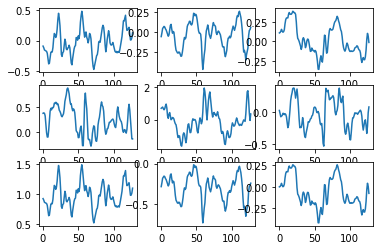

In [6]:
def plot_lines(X, nsamples):
    t = range(128)
    for i in range(9):
        plt.subplot(3,3,i+1)
        for j in range(np.minimum(X.shape[0],nsamples)):
            plt.plot(t,X[j,:,i])
    plt.show()
    
plot_lines(X_train_per_class[1], 1)

In [7]:
# Input Data
training_data_count = len(X_train)  # 7352 training series (with 50% overlap between each serie)
test_data_count = len(X_test)  # 2947 testing series
means = np.mean(X_train, axis=(0,1))
stdevs = np.std(X_train, axis=(0,1))

print("X shape, Y_shape:")
print(X_train.shape, Y_train.shape)
print(X_test.shape, Y_test.shape)
print()
print("Mean / Stdev for each feature:")
for i in range(9):
    print("%7.4f | %7.4f"%(means[i], stdevs[i]))

X shape, Y_shape:
(7352, 128, 9) (7352, 6)
(2947, 128, 9) (2947, 6)

Mean / Stdev for each feature:
-0.0006 |  0.1948
-0.0003 |  0.1224
-0.0003 |  0.1069
 0.0005 |  0.4068
-0.0008 |  0.3819
 0.0001 |  0.2557
 0.8047 |  0.4141
 0.0288 |  0.3910
 0.0865 |  0.3578


### Normalization

Can be skipped since the features are all at similar scales aready.

### Utilities

In [8]:
def performance_plots(model, X_test, Y_test, log, epochs):    
    acc = log.history['accuracy']
    val_acc = log.history['val_accuracy']
    print('Train accuracy (end):', acc[-1])
    print('Train accuracy (max):', np.max(acc))
    print('Test accuracy (end) :', val_acc[-1])
    print('Test accuracy (max) :', np.max(val_acc))

    plt.plot(log.history['accuracy'])
    plt.plot(log.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train','test'], loc='upper left')
    plt.axis([0,epochs,0.0,1.0])
    plt.show()

    plt.plot(log.history['loss'])
    plt.plot(log.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train','test'], loc = 'upper left')
    plt.axis([0,epochs,0.0,2.0])
    plt.show()

In [9]:
import sklearn
from sklearn import metrics
import pandas as pd
activities = ["walk", "up", "down", "sit", "stand", "lay"]

def confusion_matrix(model, X_test, Y_test):
    scores = model.predict(X_test)
    predictions = np.argmax(scores, axis=1)
    labels = np.argmax(Y_test, axis=1)
    cm = sklearn.metrics.confusion_matrix(labels, predictions)
    df = pd.DataFrame({activities[i] : cm[:,i] for i in range(len(activities))}, activities)
    return df

## Specify and Train Models

Try different architectures to solve the activity recognition problem.

At minimum implement
* Model with a single layer of SimpleRNN
* Model with several layers of SimpleRNNs
* Model with several CNN layers
* Mixed model with several layers of CNNs, then its output model with 1+ layers of SimpleRNNs

Try with different number of units.

Report about your findings.

In [10]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Input, Dense, Dropout, Flatten, Reshape
from tensorflow.keras.layers import SimpleRNN, Conv2D

### Single Layer SimpleRNN

In [11]:
### START YOUR CODE

model = Sequential()
model.add(Input((128, 9)))
model.add(SimpleRNN(128, return_sequences=False, activation='tanh', kernel_initializer='glorot_uniform'))
model.add(Dense(N_CLASSES, activation='softmax'))

opt = Adam(learning_rate=0.001)

model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

### END YOUR CODE

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn (SimpleRNN)       (None, 128)               17664     
_________________________________________________________________
dense (Dense)                (None, 6)                 774       
Total params: 18,438
Trainable params: 18,438
Non-trainable params: 0
_________________________________________________________________


In [12]:
### START YOUR CODE
batch_size = 32
n_epochs   = 30

log = model.fit(X_train, Y_train, batch_size=batch_size, epochs=n_epochs, validation_data=(X_test, Y_test))

Epoch 1/30
230/230 [==============================] - 6s 22ms/step - loss: 1.2282 - accuracy: 0.4812 - val_loss: 1.8189 - val_accuracy: 0.2755
Epoch 2/30
230/230 [==============================] - 5s 22ms/step - loss: 0.9597 - accuracy: 0.5884 - val_loss: 1.0130 - val_accuracy: 0.6016
Epoch 3/30
230/230 [==============================] - 5s 21ms/step - loss: 0.8601 - accuracy: 0.6330 - val_loss: 0.8819 - val_accuracy: 0.6210
Epoch 4/30
230/230 [==============================] - 5s 22ms/step - loss: 0.6912 - accuracy: 0.6938 - val_loss: 0.8262 - val_accuracy: 0.6162
Epoch 5/30
230/230 [==============================] - 5s 22ms/step - loss: 0.6466 - accuracy: 0.7251 - val_loss: 0.8088 - val_accuracy: 0.7027
Epoch 6/30
230/230 [==============================] - 5s 21ms/step - loss: 1.2761 - accuracy: 0.4936 - val_loss: 1.4722 - val_accuracy: 0.3865
Epoch 7/30
230/230 [==============================] - 5s 22ms/step - loss: 1.2291 - accuracy: 0.4770 - val_loss: 1.1767 - val_accuracy: 0.5327

Train accuracy (end): 0.8551414608955383
Train accuracy (max): 0.9173014163970947
Test accuracy (end) : 0.8116728663444519
Test accuracy (max) : 0.8798778653144836


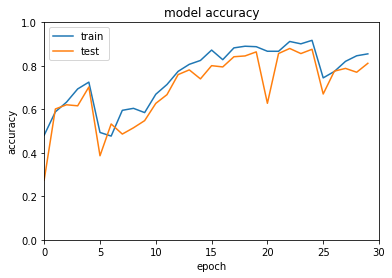

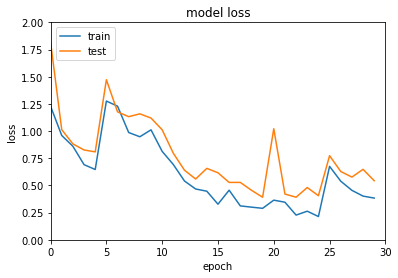

,walk,up,down,sit,stand,lay
walk,317,116,62,0,1,0
up,45,370,51,0,5,0
down,22,9,387,1,0,1
sit,0,1,0,319,171,0
stand,0,0,0,42,490,0
lay,0,27,0,1,0,509


In [13]:
performance_plots(model, X_test, Y_test, log, n_epochs)
confusion_matrix(model, X_test, Y_test)

#### Findings

The model has reached an accuaracy of 65% and the confusion matrix shows that it isn't really sure about the classes. The accuracy plot over the epochs further indicates that the model has collapsed a few times during training (spikes).

### Stacked Simple RNNs

In [14]:
### START YOUR CODE

model = Sequential()
model.add(Input((128, 9)))
model.add(SimpleRNN(128, return_sequences=True, activation='tanh', kernel_initializer='glorot_uniform'))
model.add(SimpleRNN(128, return_sequences=True, activation='tanh', kernel_initializer='glorot_uniform'))
model.add(SimpleRNN(128, return_sequences=False, activation='tanh', kernel_initializer='glorot_uniform'))
model.add(Dense(N_CLASSES, activation='softmax'))

opt = Adam(learning_rate=0.001)

model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

### END YOUR CODE

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn_1 (SimpleRNN)     (None, 128, 100)          11000     
_________________________________________________________________
simple_rnn_2 (SimpleRNN)     (None, 128, 100)          20100     
_________________________________________________________________
simple_rnn_3 (SimpleRNN)     (None, 100)               20100     
_________________________________________________________________
dense_1 (Dense)              (None, 6)                 606       
Total params: 51,806
Trainable params: 51,806
Non-trainable params: 0
_________________________________________________________________


In [15]:
### START YOUR CODE
batch_size = 32
n_epochs   = 20

log = model.fit(X_train, Y_train, batch_size=batch_size, epochs=n_epochs, validation_data=(X_test, Y_test))

Epoch 1/20
230/230 [==============================] - 14s 58ms/step - loss: 0.7228 - accuracy: 0.6944 - val_loss: 0.6893 - val_accuracy: 0.7713
Epoch 2/20
230/230 [==============================] - 13s 57ms/step - loss: 0.6325 - accuracy: 0.7507 - val_loss: 0.6256 - val_accuracy: 0.7662
Epoch 3/20
230/230 [==============================] - 13s 57ms/step - loss: 0.6651 - accuracy: 0.7292 - val_loss: 1.1615 - val_accuracy: 0.6264
Epoch 4/20
230/230 [==============================] - 13s 58ms/step - loss: 0.5197 - accuracy: 0.8025 - val_loss: 0.6361 - val_accuracy: 0.7757
Epoch 5/20
230/230 [==============================] - 13s 59ms/step - loss: 0.3345 - accuracy: 0.8849 - val_loss: 0.5957 - val_accuracy: 0.8246
Epoch 6/20
230/230 [==============================] - 13s 58ms/step - loss: 0.6154 - accuracy: 0.7643 - val_loss: 0.5987 - val_accuracy: 0.7560
Epoch 7/20
230/230 [==============================] - 13s 57ms/step - loss: 0.5164 - accuracy: 0.7875 - val_loss: 0.5843 - val_accuracy:

Train accuracy (end): 0.5171381831169128
Train accuracy (max): 0.8849292993545532
Test accuracy (end) : 0.5782151222229004
Test accuracy (max) : 0.8245673775672913


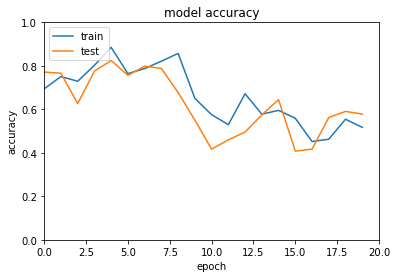

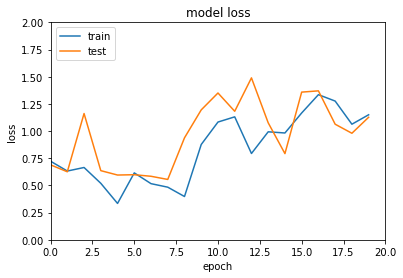

,walk,up,down,sit,stand,lay
walk,204,55,55,19,158,5
up,137,133,24,22,151,4
down,171,66,72,15,88,8
sit,9,2,2,331,145,2
stand,9,5,0,61,457,0
lay,0,26,0,3,1,507


In [16]:
performance_plots(model, X_test, Y_test, log, n_epochs)
confusion_matrix(model, X_test, Y_test)

#### Findings

It is very clear from the loss and the accuracy that the model has collapsed due to exploding gradients. The model learned for approx. 3 epochs and then started to decrease.

### Several CNN Layers

In [17]:
### START YOUR CODE
dropout_rate = 0.2

model = Sequential()
model.add(Input((128, 9, 1)))

model.add(Conv2D(filters=16, kernel_size=(5,1), strides=(2,1), activation='relu', kernel_initializer='he_normal'))
model.add(Dropout(dropout_rate))

model.add(Conv2D(filters=32, kernel_size=(3,1), strides=(2,1), activation='relu', kernel_initializer='he_normal'))
model.add(Dropout(dropout_rate))

model.add(Conv2D(filters=64, kernel_size=(3,1), strides=(2,1), activation='relu', kernel_initializer='he_normal'))
model.add(Dropout(dropout_rate))

model.add(Conv2D(filters=64, kernel_size=(3,1), strides=(2,1), activation='relu', kernel_initializer='he_normal'))
model.add(Dropout(dropout_rate))

model.add(Flatten())
model.add(Dense(N_CLASSES, activation='softmax'))

model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

### END YOUR CODE

model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 62, 9, 16)         96        
_________________________________________________________________
dropout (Dropout)            (None, 62, 9, 16)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 30, 9, 32)         1568      
_________________________________________________________________
dropout_1 (Dropout)          (None, 30, 9, 32)         0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 14, 9, 64)         6208      
_________________________________________________________________
dropout_2 (Dropout)          (None, 14, 9, 64)         0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 6, 9, 64)         

In [18]:
### START YOUR CODE
batch_size = 32
n_epochs   = 30

X_train_expanded = np.expand_dims(X_train, axis=-1)
X_test_expanded = np.expand_dims(X_test, axis=-1)

log = model.fit(X_train_expanded, Y_train, 
                batch_size=batch_size, 
                epochs=n_epochs, 
                validation_data=(X_test_expanded, Y_test))

Epoch 1/30
230/230 [==============================] - 5s 19ms/step - loss: 0.3954 - accuracy: 0.8447 - val_loss: 0.3170 - val_accuracy: 0.8850
Epoch 2/30
230/230 [==============================] - 4s 19ms/step - loss: 0.2068 - accuracy: 0.9219 - val_loss: 0.4008 - val_accuracy: 0.8728
Epoch 3/30
230/230 [==============================] - 4s 19ms/step - loss: 0.1613 - accuracy: 0.9399 - val_loss: 0.2631 - val_accuracy: 0.9033
Epoch 4/30
230/230 [==============================] - 4s 19ms/step - loss: 0.1419 - accuracy: 0.9450 - val_loss: 0.2484 - val_accuracy: 0.9094
Epoch 5/30
230/230 [==============================] - 4s 19ms/step - loss: 0.1330 - accuracy: 0.9499 - val_loss: 0.2481 - val_accuracy: 0.9135
Epoch 6/30
230/230 [==============================] - 4s 19ms/step - loss: 0.1270 - accuracy: 0.9520 - val_loss: 0.2268 - val_accuracy: 0.9196
Epoch 7/30
230/230 [==============================] - 4s 19ms/step - loss: 0.1242 - accuracy: 0.9520 - val_loss: 0.2086 - val_accuracy: 0.9182

Train accuracy (end): 0.978509247303009
Train accuracy (max): 0.978509247303009
Test accuracy (end) : 0.9375635981559753
Test accuracy (max) : 0.9487614631652832


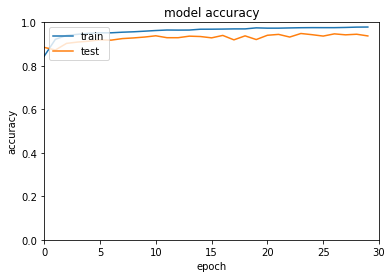

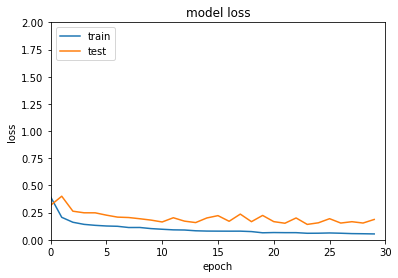

,walk,up,down,sit,stand,lay
walk,494,1,1,0,0,0
up,9,462,0,0,0,0
down,21,19,380,0,0,0
sit,1,3,0,413,74,0
stand,2,5,0,48,477,0
lay,0,0,0,0,0,537


In [19]:
performance_plots(model, X_test, Y_test, log, n_epochs)
confusion_matrix(model, X_test_expanded, Y_test)

#### Findings

The accuracy and loss shows a much stabler training that converges to a much higher accuracy then when using pure RNN architectures. This makes sense, because the model only needs to backpropagate through the layer depth instead of also over time.

### Mixed CNN and RNN

In [20]:
### START YOUR CODE

model = Sequential()
model.add(Input((128, 9, 1)))
model.add(Conv2D(16, kernel_size=(5,1), strides=(2,1), activation='relu', kernel_initializer='he_normal'))
model.add(Conv2D(32, kernel_size=(3,1), strides=(2,1), activation='relu', kernel_initializer='he_normal'))
model.add(Reshape((30,9*32)))
model.add(SimpleRNN(128, return_sequences=False, activation='tanh', kernel_initializer='glorot_uniform'))
model.add(Dense(N_CLASSES, activation='softmax'))

model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
### END YOUR CODE

model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 62, 9, 16)         96        
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 30, 9, 32)         1568      
_________________________________________________________________
reshape (Reshape)            (None, 30, 288)           0         
_________________________________________________________________
simple_rnn_4 (SimpleRNN)     (None, 100)               38900     
_________________________________________________________________
dense_3 (Dense)              (None, 6)                 606       
Total params: 41,170
Trainable params: 41,170
Non-trainable params: 0
_________________________________________________________________


In [21]:
### START YOUR CODE
batch_size = 32
n_epochs   = 30

X_train_expanded = np.expand_dims(X_train, axis=-1)
X_test_expanded = np.expand_dims(X_test, axis=-1)

log = model.fit(X_train_expanded, Y_train, 
                batch_size=batch_size, 
                epochs=n_epochs, 
                validation_data=(X_test_expanded, Y_test))

Epoch 1/30
230/230 [==============================] - 5s 18ms/step - loss: 0.4733 - accuracy: 0.7953 - val_loss: 0.5114 - val_accuracy: 0.8246
Epoch 2/30
230/230 [==============================] - 4s 18ms/step - loss: 0.2345 - accuracy: 0.9149 - val_loss: 0.4280 - val_accuracy: 0.8544
Epoch 3/30
230/230 [==============================] - 4s 17ms/step - loss: 0.1787 - accuracy: 0.9338 - val_loss: 0.3310 - val_accuracy: 0.8863
Epoch 4/30
230/230 [==============================] - 4s 17ms/step - loss: 0.1737 - accuracy: 0.9346 - val_loss: 0.3880 - val_accuracy: 0.8616
Epoch 5/30
230/230 [==============================] - 4s 17ms/step - loss: 0.1390 - accuracy: 0.9459 - val_loss: 0.2911 - val_accuracy: 0.8948
Epoch 6/30
230/230 [==============================] - 4s 17ms/step - loss: 0.1141 - accuracy: 0.9542 - val_loss: 0.3630 - val_accuracy: 0.8816
Epoch 7/30
230/230 [==============================] - 4s 17ms/step - loss: 0.1322 - accuracy: 0.9517 - val_loss: 0.6444 - val_accuracy: 0.7448

Train accuracy (end): 0.9708922505378723
Train accuracy (max): 0.9722524285316467
Test accuracy (end) : 0.9209365248680115
Test accuracy (max) : 0.9233118295669556


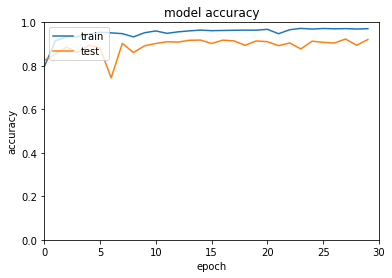

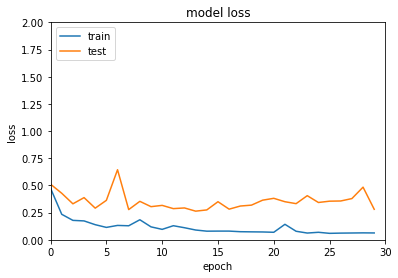

,walk,up,down,sit,stand,lay
walk,482,9,5,0,0,0
up,9,450,12,0,0,0
down,1,2,417,0,0,0
sit,0,4,0,399,88,0
stand,0,1,0,102,429,0
lay,0,0,0,0,0,537


In [22]:
performance_plots(model, X_test, Y_test, log, n_epochs)
confusion_matrix(model, X_test_expanded, Y_test)

#### Findings

The mixed CNN+RNN architecture does not seem to work as well as the pure CNN. Adding additional RNN layers includes again insabilities in the training process. 